# Two figures needed
- One is a 4x4 figure with persistence, BF, linearity turnoff, and divisadero tearing
- One is a two panel figure showing phosphorescence, with two images from a persistence dataset
- Also need some statistics on the defect prevalence across the focal plane

### Imports

In [129]:
import os
import gc
import numpy as np
from lsst.summit.utils.plotting import plot
import lsst.afw.cameraGeom.utils as camGeomUtils
import lsst.afw.math as afwMath
import lsst.afw.display as afwDisplay
import pandas as pd
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
afwDisplay.setDefaultBackend('matplotlib') 
import scipy as sp
import sys
import lsst.afw.math as afwMath
sys.path.append('/home/s/seanmacb/LSST-Camera/Defect-Analysis')
sys.path.append('/home/s/seanmacb/LSST-Camera/Extras and Utilities')
sys.path.append('/home/s/seanmacb/LSST-Camera/Extras and Utilities/pkgs')
sys.path.append('/home/s/seanmacb/LSST-Camera/Extras and Utilities/eo_pipe/python/lsst/eo/pipe')
import run_six_utils as rsu
import eo_pipe.python.lsst.eo.pipe as eo_pipe
from eo_pipe.python.lsst.eo.pipe import (readNoiseTask, darkCurrentTask, defectsTask, eperTask, divisaderoTearingTask, ptcPlotsTask,linearityPlotsTask, bfAnalysisTask)
import copy
from lsst.ip.isr import IsrTask, IsrTaskConfig
import lsst.daf.butler as daf_butler
import lsst.afw.math as afw_math
from matplotlib import pyplot as plt
plt.rcParams["font.family"] = 'serif'
plt.style.use("seaborn-v0_8-talk")
from matplotlib import lines
from mpl_toolkits import axes_grid1
from astropy.stats import sigma_clip
from scipy.stats import skew
from tabulate import tabulate
import lsst.afw.cameraGeom.utils as camGeomUtils
from scipy.stats import norm

from lsst.obs.lsst import LsstCam, LsstTS8
from IPython.display import display_html, HTML
import myutils_ar.myutils as myu
from importlib import reload

def get_run_data(acq_run,weekly='w_2023_24',operator='lsstccs',repo='/repo/ir2',verbose=0):
    
    # We use the collection naming scheme to find all of the chained collections for an eo_pipe analysis of 
    # the specified run.  For our dataset queries, we'll use these collections.
    butler = daf_butler.Butler(repo)
    collections = butler.registry.queryCollections(f"u/{operator}/eo_*_{acq_run}_{weekly}",
                                               collectionTypes=daf_butler.CollectionType.CHAINED)
    if verbose>0:
        for item in collections:
            print(item)
            
    # Several eo_pipe pipelines produce per-amp measurements for all of the CCDs in the current Camera object.
    # For LSSTCam, this would include all 205 CCDs in the focal plane; for TS8, this would be the 9 CCDs in 
    # the raft installed at that test stand (currently RTM-004).
    #
    # The `eo_pipe.get_amp_data` function will retrieve these per-amp measurements and return them as a 
    # three-level dictionary, keyed by measurement quantity, CCD (labeled by R**_S for LSSTCam), and 
    # amplifier data (labeled by channel name, e.g., 'C01').
    #
    # The '[ps]cti' quantities are measured from combined flats, so will have different values depending on the
    # filter used, since combined flats a created separately for each filter combination.
    amp_data = eo_pipe.get_amp_data(repo, collections)
    if verbose>0:
        for quantity in amp_data.keys():
            print(quantity)
            
    df_data = myu.eopipe_DictToDfz(amp_data)
    if verbose>0:
        print(df_data.columns)
        
    return amp_data,df_data


def fitGaussian(data,ax):
    mu, std = norm.fit(data) 
    
    xmin, xmax = ax.get_xlim()
    x = np.linspace(np.floor(xmin), np.ceil(xmax), int(10E4))
    p = norm.pdf(x, mu, std)

    return mu,std,p,x,xmin,xmax

def getFWHM_from_gaussian(sigma):
    return 2*np.sqrt(np.log(2)*2)*sigma

def compare_tworuns(df1,df2,run1,run2,minxy,maxxy,quantity='READ_NOISE',draw_line=True,legend_loc='lower right',title=None, scale='linear'):

    rtms = myu.get_rtms()
    crtms = myu.get_crtms()
    rtmids = myu.get_rtmids()
    allrtms = rtms + crtms

    f,ax = plt.subplots(5,5,figsize=(22,22),constrained_layout=True)
    axf = ax

    for i,abay in enumerate(allrtms):

        thertm = rtmids[abay]
        ix = 4-int(abay[1:2])
        iy = int(abay[2:3])

        # get the desired quantity, filtered by raft
        df1f = df1[df1.BAY==abay]
        df2f = df2[df2.BAY==abay]

        for aslot in myu.get_slots_per_bay(abay):

            # filter by slot
            df1fs = df1f[df1f.SLOT==aslot]
            df2fs = df2f[df2f.SLOT==aslot]

            quant1 = df1fs[quantity]
            quant2 = df2fs[quantity]

            # make sure we have entries
            if len(quant1)>0 and len(quant1)==len(quant2):
                axf[ix,iy].scatter(quant1,quant2,label=aslot)


        axf[ix,iy].text(0.07,0.9,'%s %s' % (abay,thertm),transform=axf[ix,iy].transAxes)
        axf[ix,iy].set_xlabel('%s Run %s' % (quantity,run1))
        axf[ix,iy].set_ylabel('%s Run %s' % (quantity,run2))

        axf[ix,iy].set_xlim(minxy,maxxy)
        axf[ix,iy].set_ylim(minxy,maxxy)

        ax[ix,iy].set_xscale(scale)
        ax[ix,iy].set_yscale(scale)

        if (ix==0 and iy==0) or (ix==0 and iy==1):
            axf[ix,iy].legend(loc=legend_loc)

        if draw_line:
            line = lines.Line2D([minxy,maxxy], [minxy,maxxy], lw=2., color='r', alpha=0.4)
            axf[ix,iy].add_line(line)
    if title!=None:
        f.suptitle(title)

    return f

def showAndClear(fig):
    plt.show()
    # Clear the current axes.
    plt.cla() 
    # Clear the current figure.
    plt.clf() 
    # Closes all the figure windows.
    plt.close('all')   
    plt.close(fig)
    
    return

def compare_changes(df1,df2,run1,run2,minx,maxx,miny,maxy, quantity='READ_NOISE',draw_line=True,legend_loc='lower right',scale='linear'):

    rtms = myu.get_rtms()
    crtms = myu.get_crtms()
    rtmids = myu.get_rtmids()
    allrtms = rtms + crtms

    f,ax = plt.subplots(5,5,figsize=(22,22),constrained_layout=True)
    axf = ax

    for i,abay in enumerate(allrtms):

        thertm = rtmids[abay]
        ix = 4-int(abay[1:2])
        iy = int(abay[2:3])

        # get the desired quantity, filtered by raft
        df1f = df1[df1.BAY==abay]
        df2f = df2[df2.BAY==abay]

        for aslot in myu.get_slots_per_bay(abay):

            # filter by slot
            df1fs = df1f[df1f.SLOT==aslot]
            df2fs = df2f[df2f.SLOT==aslot]

            quant1 = df1fs[quantity]
            quant2 = df2fs[quantity]

            # make sure we have entries
            if len(quant1)>0 and len(quant1)==len(quant2):
                axf[ix,iy].scatter(quant1,quant2-quant1,label=aslot)


        axf[ix,iy].text(0.07,0.9,'%s %s' % (abay,thertm),transform=axf[ix,iy].transAxes)
        axf[ix,iy].set_xlabel('%s Run %s' % (quantity,run1))
        axf[ix,iy].set_ylabel(f'{quantity} {run2} - {run1}')

        axf[ix,iy].set_xlim(minx,maxx)
        axf[ix,iy].set_ylim(miny,maxy)

        ax[ix,iy].set_xscale(scale)
        ax[ix,iy].set_yscale(scale)

        if (ix==0 and iy==0) or (ix==0 and iy==1):
            axf[ix,iy].legend(loc=legend_loc)

        if draw_line:
            line = lines.Line2D([minx,miny], [maxx,maxy], lw=2., color='r', alpha=0.4)
            axf[ix,iy].add_line(line)


def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption).hide(axis='index').to_html()
    display(HTML(output))
    
    return output


def print_diff(df1, df2, run1, run2, quantity, thresh, low_thresh=0, change_thresh=0.1, print_large_change=True):
    
    ind1 = (df1[quantity]>thresh)
    ind1_low = (df1[quantity]<low_thresh)
    ind2 = (df2[quantity]>thresh) 
    ind2_low = (df2[quantity]<low_thresh)
    ind3 = ( np.abs(df1[quantity] - df2[quantity])/np.abs(df1[quantity]) > change_thresh)

    indices = list(df1[ind1].index) + list(df2[ind2].index)
    indices += list(df1[ind1_low].index) + list(df2[ind2_low].index)
    
    if print_large_change:
        indices += list(df1[ind3].index)
        indices += list(df2[ind3].index)

    indices = list(np.unique(indices))

    cols = ['BAY_SLOT','SEGMENT']
    display_side_by_side([df1.loc[indices][cols],
                          df1.loc[indices][[quantity]], 
                          df2.loc[indices][[quantity]]], 
                         ['Sensor', run1, run2])   
    

def dictParser(inString):
    
    splitDict = inString.split("]],")
    
    realDict= {}
    
    for line in splitDict:
        line +="]]"
        if line==splitDict[0]:
            line = line[1:]
        elif line==splitDict[-1]:
            line = line[:-1]
        key,val = line.split(":")
        raft_key = key.split("'")[1]
    
        first, second = val.split("],")
        
        newfirst = first[3:]
        realFirst = []
        for entry in newfirst.split(","):
            realFirst.append(int(entry))
    
        realSecond = []
        newsecond = second[2:].split("]")
        for entry in newsecond[0].split(","):
            realSecond.append(int(entry))

        subDict = {}

        for firstVal,secondVal in zip(realFirst,realSecond):
            subDict[firstVal] = secondVal
    
        realDict[raft_key] = subDict

    return realDict

def getPersistDF(acq_run,repo = '/repo/embargo_new',operator = 'lsstccs',weekly = 'w_2024_35'):

    # We use the collection naming scheme to find all of the chained collections for an eo_pipe analysis of 
    # the specified run.  For our dataset queries, we'll use these collections.
    butler = daf_butler.Butler(repo)
    collections_ref = butler.registry.queryCollections(f"u/{operator}/eo_persistence_{acq_run}_{weekly}",
                                               collectionTypes=daf_butler.CollectionType.CHAINED)
    for item in collections_ref:
        print(item)
    
    dstype = 'persistence_data'
    butler_col = daf_butler.Butler(repo, collections=collections_ref)

    dslist = []
    refs = list(set(butler_col.registry.queryDatasets(dstype, findFirst=True).expanded()))
    print(len(refs))

    for aref in refs:
        dslist.append(butler_col.get(aref))
        
    dsall = pd.concat(dslist)
    return dsall

# code to get a single persistence value per amp.
def getAllPersistence(dsall):

    camera = LsstCam.getCamera()
    det_names = {i: det.getName() for i, det in enumerate(camera)}

    outdict = {}
    dfdict = {}
    detname_list = []
    ampname_list = []
    persist_list = []
    dettype_list = []
    
    for detnum,det in enumerate(camera):
        detname = det.getName()
        segments = [amp.getName() for amp in camera[detnum].getAmplifiers()]  #these are in order of amp

        outdict[detname] = {}
        for segment in segments:
            selone = (dsall['det_name']==detname) & (dsall['amp_name']==segment)
            dsone = dsall[selone]

            # calculate the difference between 1st point after t=0 and the last 5 points
            persist_arr = dsone['mean_signal'].to_numpy()
            if len(persist_arr)==0:
                persist_value = 0.
            else:
                persist_value = persist_arr[1] - np.mean(persist_arr[-5:])
            outdict[detname][segment] = persist_value

            detname_list.append(detname)
            dettype_list.append(det.getPhysicalType())
            ampname_list.append(segment)
            persist_list.append(persist_value)

    dfdict['det_name'] = detname_list
    dfdict['amp_name'] = ampname_list
    dfdict['det_type'] = dettype_list
    dfdict['persist'] = persist_list
    dfout = pd.DataFrame(dfdict)

    return outdict,dfout

## 4x4 figure first

In [33]:
daf_butler.Butler("/repo/ir2").registry.queryCollections("*ptc*13550*")

['u/lsstccs/ptc_13550_w_2023_41/20231116T224523Z',
 'u/lsstccs/eo_ptc_plots_13550_w_2023_41/20231117T001049Z',
 'u/lsstccs/ptc_13550_w_2023_41',
 'u/lsstccs/eo_ptc_plots_13550_w_2023_41']

In [39]:
run7Persist = getAllPersistence(getPersistDF("E1880"))[1]
run6Persist = getAllPersistence(getPersistDF(13550,repo='/repo/ir2',weekly='w_2023_41'))[1]

u/lsstccs/eo_persistence_E1880_w_2024_35
197
u/lsstccs/eo_persistence_13550_w_2023_41
205


In [24]:
run6Divis = myu.eopipe_DictToDfz(divisaderoTearingTask.get_amp_data("/repo/ir2","u/lsstccs/eo_divisadero_tearing_13550_w_2023_41"))
run7Divis = myu.eopipe_DictToDfz(divisaderoTearingTask.get_amp_data("embargo_new","u/lsstccs/eo_divisadero_tearing_E1880_w_2024_35"))

In [28]:
run6Linearity = myu.eopipe_DictToDfz(linearityPlotsTask.get_amp_data("/repo/ir2","u/lsstccs/eo_linearity_plots_13557_w_2023_41"))
run7Linearity = myu.eopipe_DictToDfz(linearityPlotsTask.get_amp_data("embargo_new","u/lsstccs/eo_linearity_plots_E1881_w_2024_35"))

In [37]:
run6PTC = myu.eopipe_DictToDfz(ptcPlotsTask.get_amp_data("/repo/ir2","u/lsstccs/eo_ptc_plots_13557_w_2023_41"))
run7PTC = myu.eopipe_DictToDfz(ptcPlotsTask.get_amp_data("embargo_new","u/lsstccs/eo_ptc_plots_E1881_w_2024_35"))

In [40]:
np.shape(run6PTC),np.shape(run7PTC),np.shape(run6Linearity),np.shape(run7Linearity),np.shape(run6Divis),np.shape(run7Divis),np.shape(run7Persist),np.shape(run6Persist)

((3216, 11),
 (3088, 11),
 (3216, 9),
 (3088, 9),
 (3216, 7),
 (3024, 7),
 (3216, 4),
 (3216, 4))

In [48]:
run6PTC["BAY_SLOT_SEGMENT"] = run6PTC["BAY_SLOT"] + "_" + run6PTC["SEGMENT"]
run7PTC["BAY_SLOT_SEGMENT"] = run7PTC["BAY_SLOT"] + "_" + run7PTC["SEGMENT"]
run6Divis["BAY_SLOT_SEGMENT"] = run6Divis["BAY_SLOT"] + "_" + run6Divis["SEGMENT"]
run7Divis["BAY_SLOT_SEGMENT"] = run7Divis["BAY_SLOT"] + "_" + run7Divis["SEGMENT"]
run6Linearity["BAY_SLOT_SEGMENT"] = run6Linearity["BAY_SLOT"] + "_" + run6Linearity["SEGMENT"]
run7Linearity["BAY_SLOT_SEGMENT"] = run7Linearity["BAY_SLOT"] + "_" + run7Linearity["SEGMENT"]
run6Persist["BAY_SLOT_SEGMENT"] = run6Persist["det_name"] + "_" + run6Persist["amp_name"]
run7Persist["BAY_SLOT_SEGMENT"] = run7Persist["det_name"] + "_" + run7Persist["amp_name"]

In [53]:
run6DF = run6PTC.merge(run6Divis,on="BAY_SLOT_SEGMENT").merge(run6Linearity,on="BAY_SLOT_SEGMENT").merge(run6Persist,on="BAY_SLOT_SEGMENT")
run7DF = run7PTC.merge(run7Divis,on="BAY_SLOT_SEGMENT").merge(run7Linearity,on="BAY_SLOT_SEGMENT").merge(run7Persist,on="BAY_SLOT_SEGMENT")

In [54]:
run7DF

,PTC_TURNOFF,PTC_NOISE,PTC_GAIN,PTC_A00,ROW_MEAN_VAR_SLOPE,BAY_x,SLOT_x,AMP_x,BAYTYPE_x,BAY_SLOT_x,...,BAY,SLOT,AMP,BAYTYPE,BAY_SLOT,SEGMENT,det_name,amp_name,det_type,persist
0,71236.180081,6.330866,1.742583,0.000002,0.908932,R01,S00,0,S,R01_S00,...,R01,S00,0,S,R01_S00,C10,R01_S00,C10,ITL,0.518310
1,68904.242902,6.267174,1.749073,0.000002,0.916001,R01,S00,1,S,R01_S00,...,R01,S00,1,S,R01_S00,C11,R01_S00,C11,ITL,0.248459
2,68252.397785,6.293710,1.752329,0.000002,0.914916,R01,S00,2,S,R01_S00,...,R01,S00,2,S,R01_S00,C12,R01_S00,C12,ITL,0.411640
3,69011.472378,6.489278,1.749682,0.000002,1.047504,R01,S00,3,S,R01_S00,...,R01,S00,3,S,R01_S00,C13,R01_S00,C13,ITL,0.379867
4,70068.275647,6.632312,1.741853,0.000002,1.160116,R01,S00,4,S,R01_S00,...,R01,S00,4,S,R01_S00,C14,R01_S00,C14,ITL,0.411012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3019,32495.664508,5.739678,1.634799,0.000003,10.011567,R43,S22,11,S,R43_S22,...,R43,S22,11,S,R43_S22,C04,R43_S22,C04,ITL,0.049361
3020,26861.083731,5.871378,1.649768,0.000002,9.070928,R43,S22,12,S,R43_S22,...,R43,S22,12,S,R43_S22,C03,R43_S22,C03,ITL,0.271873
3021,23253.874250,5.956035,1.656139,0.000004,7.789058,R43,S22,13,S,R43_S22,...,R43,S22,13,S,R43_S22,C02,R43_S22,C02,ITL,0.502208
3022,19279.734060,6.361376,1.662279,0.000003,5.882998,R43,S22,14,S,R43_S22,...,R43,S22,14,S,R43_S22,C01,R43_S22,C01,ITL,0.233057


In [115]:
persistKwargs = {"bins":np.arange(0,11.1,step=0.2)}
a00Kwargs = {"bins":np.arange(2.25E-6,4.25001E-6,step=0.5E-7)}
turnoffKwargs = {"bins":np.arange(70000,145001,step=2E3)}
divisaderoKwargs = {"bins":np.arange(0,0.0201,step=0.0005)}

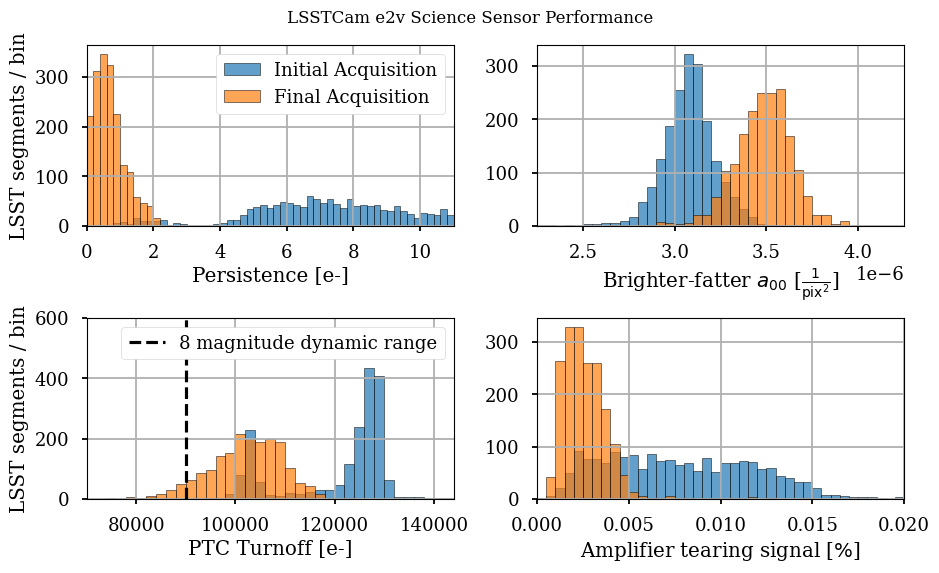

In [117]:
fig, axs = plt.subplots(2,2,figsize=(9.5,5.8))
fig.suptitle("LSSTCam e2v Science Sensor Performance")
for ax,col,kwargs in zip(axs.flatten(),["persist","PTC_A00","PTC_TURNOFF","DIVISADERO_TEARING"],[persistKwargs,a00Kwargs,turnoffKwargs,divisaderoKwargs]):
    ax.grid()
    for df,runNum,legendLab in zip([run6DF,run7DF],["Run 6","Run 7"],["Initial Acquisition","Final Acquisition"]):
        typeMask = [myu.det_ptypes[myu.det_nums[x]] for x in df["BAY_SLOT"]]
        for manu in ["E2V"]: # ,"ITL"
            mask = [x==manu for x in typeMask]
            if col=="persist" or col=="PTC_TURNOFF":
                quant = df[mask][col] * df[mask]["PTC_GAIN"] 
            else:
                quant = df[mask][col] 
            ax.hist(quant,alpha=0.7,weights=np.full(np.shape(quant),1),**kwargs,label="{}".format(legendLab),edgecolor='black', linewidth=0.5)
    ax.set_xlim(np.min(kwargs["bins"]),np.max(kwargs["bins"]))
    if col=="PTC_TURNOFF":
        line = ax.axvline(90000,ls="--",color='black',label="8 magnitude requirement")
        ax.set_xlabel("PTC Turnoff [e-]")
        ax.legend([line], ["8 magnitude dynamic range"],framealpha=1)
        ax.set_ylim(0,600)
    elif col=="PTC_A00":
        ax.set_xlabel(r"Brighter-fatter $a_{00}$ [$\frac{1}{\text{pix}^2}$]")
    elif col=="persist":
        ax.legend(framealpha=1)
        ax.set_xlabel(r"Persistence [e-]")
    elif col=="DIVISADERO_TEARING":
        ax.set_xlabel(r"Amplifier tearing signal [$\%$]")
# axs[1,0].set_xticks(np.arange(90000,180001,20000))
for ax in axs[:,0]:
    ax.set_ylabel("LSST segments / bin")
fig.tight_layout()
fig.savefig(os.getcwd()+"/4x4Figure.jpg",dpi=180)

## Phosphorescent images
- Use detector 184
- Simple ISR
- Try 20241030432 and 20241030451

In [125]:
detector = 184
expId1 = 2024103000432
expId2 = 2024103000451

In [126]:
isrConfig = IsrTaskConfig()
isrConfig.doLinearize=False
isrConfig.doOverscan=True
isrConfig.overscan.fitType="MEDIAN_PER_ROW"
isrConfig.overscan.doParallelOverscan=True
isrConfig.doAssembleCcd=True
isrConfig.doBias=False
isrConfig.doVariance=False
isrConfig.doCrosstalk=False
isrConfig.doBrighterFatter=False
isrConfig.doDark=False
isrConfig.doStrayLight=False
isrConfig.doFlat=False
isrConfig.doFringe=False
isrConfig.doApplyGains=True
isrConfig.usePtcGains=False
isrConfig.doDefect=False
isrConfig.doNanMasking=True
isrConfig.doInterpolate=False
isrConfig.doSaturation=False
isrConfig.doSaturationInterpolation=False
isrTask = IsrTask(config=isrConfig)

In [127]:
butler = daf_butler.Butler('embargo_new', collections=['LSSTCam/raw/all', 'LSSTCam/calib/unbounded'])

In [150]:
instrument = 'LSSTCam'
exp1 = butler.get('raw', detector=detector, exposure=expId1, instrument=instrument)
isrResult1 = isrTask.run(exp1) # This runs the ISR
instrument = 'LSSTCam'
exp2 = butler.get('raw', detector=detector, exposure=expId2, instrument=instrument)
isrResult2 = isrTask.run(exp2) # This runs the ISR

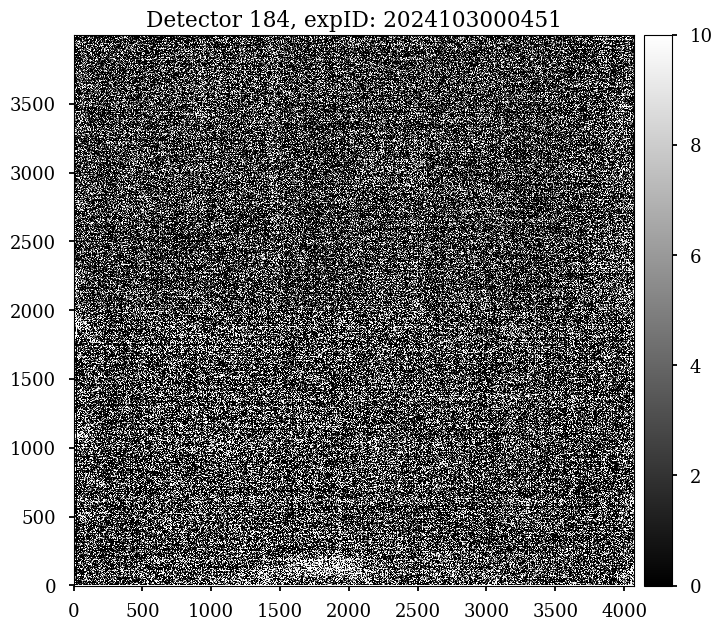

In [163]:
%matplotlib inline
disp = afwDisplay.Display()
disp.scale("linear",0,10)
disp.mtv(isrResult2.exposure,title=f"Detector {detector}, expID: {expId2}")
plt.savefig(os.getcwd()+"/{}.jpg".format(expId2),dpi=200)

<Figure size 1040x715 with 0 Axes>

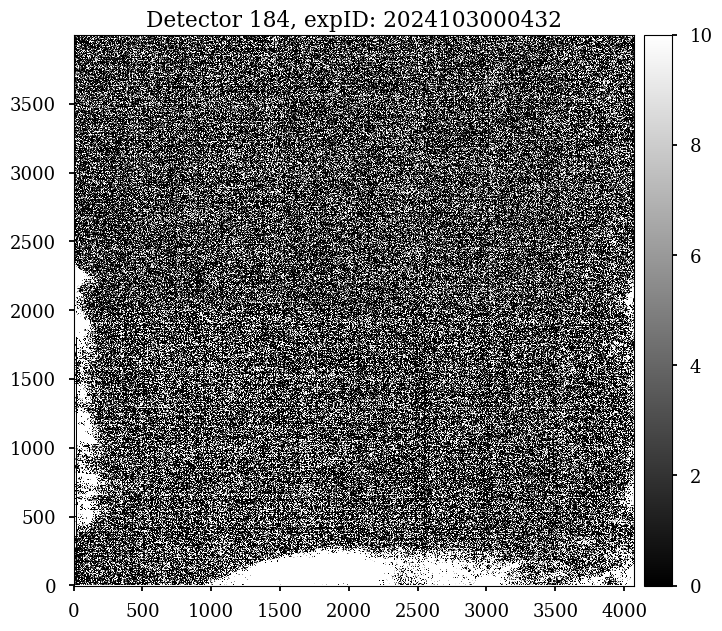

In [162]:
%matplotlib inline
plt.figure()
disp = afwDisplay.Display()
disp.scale("linear",0,10)
disp.mtv(isrResult1.exposure,title=f"Detector {detector}, expID: {expId1}")
plt.savefig(os.getcwd()+"/{}.jpg".format(expId1),dpi=200)

## Final thing
Statistics on bright and dark defects
- Median count of pixels masked
- Scale to number of pixels in each segment, dependent on amp type

In [166]:
# daf_butler.Butler("/repo/ir2").registry.queryCollections("*defect*13550*")
run6Collections = ['u/lsstccs/defects_13550_w_2023_41','u/lsstccs/eo_bright_defects_13550_w_2023_41','u/lsstccs/eo_dark_defects_13550_w_2023_41']

In [244]:
# daf_butler.Butler("embargo_new").registry.queryCollections("*seanmacb*")
run7Collections = ['u/lsstccs/defects_E1880_w_2024_35','u/lsstccs/eo_bright_defects_E1880_w_2024_35','u/seanmacb/eoDarkDefects.9_9.sitcomtn-148.E1880']

['u/seanmacb/eoDarkDefects.9_2/20241031T193404Z',
 'u/seanmacb/eoDarkDefects.3_9/20241031T193907Z',
 'u/seanmacb/eoDarkDefects.9_9/20241031T185852Z',
 'u/seanmacb/eoDarkDefects.9_8/20241031T193003Z',
 'u/seanmacb/eoDarkDefects.5_9/20241031T193755Z',
 'u/seanmacb/eoDarkDefects.9_3/20241031T193320Z',
 'u/seanmacb/eoDarkDefects.8_9/20241031T193559Z',
 'u/seanmacb/eoDarkDefects.6_9/20241031T193716Z',
 'u/seanmacb/eoDarkDefects.0_9/20241031T194055Z',
 'u/seanmacb/eoDarkDefects.2_9/20241031T193943Z',
 'u/seanmacb/eoDarkDefects.9_5/20241031T193203Z',
 'u/seanmacb/eoDarkDefects.9_1/20241031T193441Z',
 'u/seanmacb/eoDarkDefects.7_9/20241031T193639Z',
 'u/seanmacb/eoDarkDefects.1_9/20241031T194019Z',
 'u/seanmacb/eoDarkDefects.9_0/20241031T193519Z',
 'u/seanmacb/eoDarkDefects.9_4/20241031T193240Z',
 'u/seanmacb/eoDarkDefects.4_9/20241031T193831Z',
 'u/seanmacb/eoDarkDefects.9_6/20241031T193125Z',
 'u/seanmacb/eoDarkDefects.9_7/20241031T193047Z',
 'u/seanmacb/eoDarkDefects.9_7/20241101T131340Z',


In [251]:
daf_butler.Butler("embargo_new").registry.queryDatasetTypes("eo*efec*")

[DatasetType('eoBrightDefects', {instrument, detector}, Defects),
 DatasetType('eoMeasureBrightDefects_metadata', {instrument, detector}, TaskMetadata),
 DatasetType('eoMeasureBrightDefects_config', {}, Config),
 DatasetType('eoMeasureBrightDefects_log', {instrument, detector}, ButlerLogRecords),
 DatasetType('eoMeasureDarkDefectsWithFilter_config', {}, Config),
 DatasetType('eoMeasureDarkDefectsWithFilter_metadata', {band, instrument, detector, physical_filter}, TaskMetadata),
 DatasetType('eoMeasureDarkDefectsWithFilter_log', {band, instrument, detector, physical_filter}, ButlerLogRecords),
 DatasetType('eoDarkDefects', {band, instrument, detector, physical_filter}, Defects),
 DatasetType('eoMeasurePhosphorescentDefectsWithFilter_metadata', {band, instrument, detector, physical_filter}, TaskMetadata),
 DatasetType('eoMeasurePhosphorescentDefectsWithFilter_log', {band, instrument, detector, physical_filter}, ButlerLogRecords),
 DatasetType('eoMeasurePhosphorescentDefectsWithFilter_con

In [260]:
refs1 = daf_butler.Butler("embargo_new").query_datasets("eoDarkDefects",collections=run7Collections[2],where="instrument='LSSTCam'")
refs2 = daf_butler.Butler("/repo/ir2").query_datasets("eoDarkDefects",collections=run6Collections[2],where="instrument='LSSTCam'")

In [261]:
pixCountDict1 = {}
for ref in refs1:
    defe = daf_butler.Butler("embargo_new").get(ref)
    table = defe.toTable()[0]
    totPix = np.sum(table["width"]*table["height"])
    pixCountDict1[defe.getMetadata().toDict()["DET_NAME"]] = totPix

In [262]:
detTypes = [myu.det_ptypes[y] for y in [myu.det_nums[x] for x in pixCountDict1.keys()]]

In [263]:
e2vDef = []
ITLDef = []
for detType,val in zip(detTypes,pixCountDict1.values()):
    if detType=="E2V":
        e2vDef.append(val)
    elif detType=="ITL":
        ITLDef.append(val)

In [265]:
np.median(np.array(e2vDef)/(4096*4004))*100,np.median(np.array(ITLDef)/(4072*4000))*100

(np.float64(0.4326301140265984), np.float64(0.14545984774066797))